# Оценка результатов A/B-теста

## Вводные данные

Нам поступила задача оценить качество и результаты A/B-теста. Для выполнения задачи был предоставлен датасет с действиями пользователей, техническое задание и вспомогательные датасеты.

**Техническое задание**

•	Название теста: recommender_system_test;

•	группы: А — контрольная, B — новая платёжная воронка;

•	дата запуска: 2020-12-07;

•	дата остановки набора новых пользователей: 2020-12-21;

•	дата остановки: 2021-01-04;

•	аудитория: 15% новых пользователей из региона EU;

•	назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

•	ожидаемое количество участников теста: 6000.

•	ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%: 
        - конверсии в просмотр карточек товаров — событие product_page,
        - просмотры корзины — product_cart,
        - покупки — purchase.


### Планы исследования

Для выполнения задачи мы выполним следующие шаги:

1. Загрузим, изучим и подготовим данные к анализу
2. Оценим корректность проведения теста, для этого проверим пересечение тестовой аудитории с конкурирующим тестом, возможные совпадения теста и маркетинговых событий, а также проблемы временных границ теста.
3. Проанализируем результаты теста
4. Оформим выводы

## Загрузка и подготовка данных к анализу

Загрузим необходимые библиотеки и переданный нам датасет

In [1]:
# импортируем необходимые нам библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as math
import collections
from collections import defaultdict
import datetime as dt
from cycler import cycler
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
from IPython.display import display, HTML
import warnings
from statsmodels.stats.proportion import proportions_ztest

#введем некотрые настройки
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 400)
plt.rcParams.update({'figure.figsize': (15,8)})

In [2]:
#Подключим файлы с данными 

try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')


try:
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')


try:
    users_event = pd.read_csv('/datasets/final_ab_events.csv')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')


try:
    users = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')

файл с данными подключен
файл с данными подключен
файл с данными подключен
файл с данными подключен


Согласно описанию данных предоставленому заказчиком:

marketing_events — календарь маркетинговых событий на 2020 год.

Структура файла:

•	name — название маркетингового события;

•	regions — регионы, в которых будет проводиться рекламная кампания;

•	start_dt — дата начала кампании;

•	finish_dt — дата завершения кампании.


new_users — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

•	user_id — идентификатор пользователя;

•	first_date — дата регистрации;

•	region — регион пользователя;

•	device — устройство, с которого происходила регистрация.


users_event — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

•	user_id — идентификатор пользователя;

•	event_dt — дата и время покупки;

•	event_name — тип события;

•	details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.


users — таблица участников тестов.

Структура файла:

•	user_id — идентификатор пользователя;

•	ab_test — название теста;

•	group — группа пользователя.



Проверим полученные данные

In [3]:
print('Таблица marketing_events — календарь маркетинговых событий на 2020 год.')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
marketing_events.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(marketing_events.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
marketing_events.sample(5, random_state=1)

Таблица marketing_events — календарь маркетинговых событий на 2020 год.
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes
 
Описание данных
                            name regions    start_dt   finish_dt
count                         14      14          14          14
unique                        14       6          14          14
top     Christmas&New Year Promo    APAC  2020-05-09  2020-05-03
freq                           1       4           1           1
 
Случайная выборка данных


,name,regions,start_dt,finish_dt
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В целом данные чистые. Строк немного, необходимо преобразовать значения столбцов с датами маркетинговых событий в формат даты.

Проверим наличие дубликатов и пропусков

In [4]:
print('\033[1m' + 'Количество пропусков:' + '\033[0m')
display(marketing_events.isna().sum())
print('=' * 45)
print()

print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m', 
      marketing_events.duplicated().sum())

Количество пропусков:


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


Количество явных дубликатов: 0


In [5]:
print('Таблица new_users — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
new_users.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(new_users.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
new_users.sample(5, random_state=1)

Таблица new_users — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB
 
Описание данных
                 user_id  first_date region   device
count              61733       61733  61733    61733
unique             61733          17      4        4
top     D794AAA811213F0E  2020-12-21     EU  Android
freq                   1        6290  46270    27520
 
Случайная выборка данных


,user_id,first_date,region,device
48237,02CC199625AFDAE6,2020-12-12,EU,Android
30424,7B48E72587EFD2C5,2020-12-16,EU,iPhone
41509,4CF8E8855FB1A493,2020-12-11,EU,iPhone
16079,4734A67AF2ABE4A2,2020-12-21,EU,PC
31356,8EE10B875F4C87FB,2020-12-23,EU,PC


В целом данные чистые. Новые пользователи видимо указаны не из всех регионов, необходимо преобразовать значения столбцов с датами маркетинговых событий в формат даты.

Проверим наличие дубликатов и пропусков

In [6]:
print('\033[1m' + 'Количество пропусков:' + '\033[0m')
display(new_users.isna().sum())
print('=' * 45)
print()

print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m', 
      new_users.duplicated().sum())

Количество пропусков:


user_id       0
first_date    0
region        0
device        0
dtype: int64


Количество явных дубликатов: 0


In [7]:
print('Таблица users_event — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
users_event.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(users_event.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
users_event.sample(5, random_state=1)

Таблица users_event — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
 
Описание данных
            details
count  62740.000000
mean      23.877631
std       72.180465
min        4.990000
25%        4.990000
50%        4.990000
75%        9.990000
max      499.990000
 
Случайная выборка данных


,user_id,event_dt,event_name,details
430731,461D7854B605AAB9,2020-12-27 23:34:25,login,NaN
381054,D782133D1D8B85BE,2020-12-22 21:08:44,login,NaN
65035,AC4949137A02EAA0,2020-12-08 06:02:05,product_cart,NaN
415170,D65AC7DF92658B02,2020-12-25 03:13:54,login,NaN
195543,474B8825FC16CBFB,2020-12-20 15:30:27,product_page,NaN


В целом данные чистые. Необходимо преобразовать значения столбца с датами в формат даты.

Проверим наличие дубликатов и пропусков

In [8]:
print('\033[1m' + 'Количество пропусков:' + '\033[0m')
display(users_event.isna().sum())
print('=' * 45)
print()

print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m', 
      users_event.duplicated().sum())

Количество пропусков:


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


Количество явных дубликатов: 0


Очевидно, что в столбце details значения указаны не во всех из 440317 действий пользователя, а скорее в нескольких действиях.

In [9]:
print('Таблица users — таблица участников тестов')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
users.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(users.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
users.sample(5, random_state=1)

Таблица users — таблица участников тестов
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB
 
Описание данных
                 user_id  group            ab_test
count              18268  18268              18268
unique             16666      2                  2
top     8FFA1D6F89AAEA40      A  interface_eu_test
freq                   2   9655              11567
 
Случайная выборка данных


,user_id,group,ab_test
4289,5DD8AA22AD471522,A,recommender_system_test
2266,CFF7906685D67807,B,recommender_system_test
3612,F96F169EAD97EA46,A,recommender_system_test
1183,AA364AF6A253170F,A,recommender_system_test
6544,5036F8CD09C38E31,B,recommender_system_test


В целом данные чистые. Необходимо преобразовать значения столбца с датами в формат даты.

Проверим наличие дубликатов и пропусков

In [10]:
print('\033[1m' + 'Количество пропусков:' + '\033[0m')
display(users.isna().sum())
print('=' * 45)
print()

print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m', 
      users.duplicated().sum())

Количество пропусков:


user_id    0
group      0
ab_test    0
dtype: int64


Количество явных дубликатов: 0


Проверим нет ли у нас одинаковых пользователей, которые оказались в разных группах нашего теста. Это крайне плохо для корректного АВ-теста

In [11]:
#проверим дубликаты по группам А и В

our_test = users.query('ab_test == "recommender_system_test"')
users_group = our_test.groupby('user_id')['group'].nunique()

dubles = users_group[users_group > 1].index 

print('Задвоений в группах: ',len(dubles))

Задвоений в группах:  0


Задвоения в группах в нашем тесте нет

## Предобработаем данные

Переведем столбцы времени в формат даты. А также переименуем все столбцы с dt в date

In [12]:
#переведем столбцы в формат даты
users_event['event_dt'] = pd.to_datetime(users_event['event_dt'], format='%Y-%m-%d')
users_event['event_dt'] = pd.to_datetime(users_event['event_dt'].dt.date)

new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')   
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')

# переименуем столбцы
users_event = users_event.rename(columns = {'event_dt':'event_date'})

# переименуем столбцы
marketing_events = marketing_events.rename(columns = {'start_dt': 'start_date', 
               'finish_dt': 'finish_date'})

# проверим результат
users_event.info()
display(users_event.head())
print(' ')
new_users.info()
display(new_users.head())
print(' ')
marketing_events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_date    440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_date,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99
1,7B6452F081F49504,2020-12-07,purchase,9.99
2,9CD9F34546DF254C,2020-12-07,purchase,4.99
3,96F27A054B191457,2020-12-07,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07,purchase,4.99


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name           14 non-null object
regions        14 non-null object
start_date     14 non-null datetime64[ns]
finish_date    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


### Промежуточные выводы

Данные чистые и их хватает для анализа. Дополнительно мы перевели столбцы времени в формат даты. А также переименовали все столбцы с dt в date. Задвоения пользователей у нас в группах нет.

## Оценка корректности проведения теста

Оценим корректность проведения теста, для этого проверим пересечение тестовой аудитории с конкурирующим тестом, возможные совпадения теста и маркетинговых событий, а также проблемы временных границ теста.

Из технического задания, у нас есть условия, которые мы можем применить для проверки корректности проведения теста

•	Название теста: recommender_system_test;

•	группы: А — контрольная, B — новая платёжная воронка;

•	дата запуска: 2020-12-07;

•	дата остановки набора новых пользователей: 2020-12-21;

•	дата остановки: 2021-01-04;

•	аудитория: 15% новых пользователей из региона EU;

•	ожидаемое количество участников теста: 6000.


Проверим пересечения нашего теста с конкурирующими тестами. Выведем нашу аудиторию исходя из ТЗ: добавим новых пользователей из региона EU которые появились с даты запуска по дату остановки набора новых пользователей

In [13]:
#добавим новых пользователей из нашего региона
n_users = new_users[(new_users['region'] == 'EU') & (new_users['first_date'] >= dt.datetime(2020,12,7).strftime('%Y-%m-%d')) & (new_users['first_date'] <= dt.datetime(2020,12,21).strftime('%Y-%m-%d'))]
new_users_eu = n_users.shape[0]

#проверим результат
print('Новые пользователи региона EU с  даты запуска по дату остановки набора новых пользователей:', new_users_eu)

Новые пользователи региона EU с  даты запуска по дату остановки набора новых пользователей: 42340


Проверим, нет ли у нас задвоения групп А и В с новыми пользователями 

In [14]:
#присоеденим новых пользователей
tests_eu = n_users.merge(users, on=['user_id'], how='inner')

#проверим дубликаты по нашей группе
our_test = tests_eu.query('ab_test == "recommender_system_test"')
users_group = our_test.groupby('user_id')['group'].nunique()

dubles = users_group[users_group > 1].index 

print('Задвоений в группах: ',len(dubles))

Задвоений в группах:  0


Задвоения в нашем тесте у новых пользователей нет. Проверим, нет ли пересечения с конкурирующим тестом или тестами. Если такие пересечения есть, то необходимо будет принимать решение по корректности проведения теста, данного нам на проверку

In [15]:
# сделаем список пользователей, которые участвуют в нашем тесте
test_users_ids = list(tests_eu.query('ab_test == "recommender_system_test"')['user_id'])

#заодно проверим сколько их
print('Количество пользователей, участвовавших в тесте "recommender_system_test":', len(test_users_ids))

Количество пользователей, участвовавших в тесте "recommender_system_test": 6351


Это количество пользователей в целом соответсвует техническому заданию. Проверим заодно процент новых пользователей, согласно техническому заданию он должен составить 15% из зоны EU

In [16]:
print('Процент новых пользователей в тесте:',round(len(test_users_ids) / new_users_eu * 100, 1))

Процент новых пользователей в тесте: 15.0


Процент новых пользователей соответсвует техническому заданию.

In [17]:
users_in_manytests = (tests_eu.query('user_id in @test_users_ids')
                      .groupby('ab_test'))

print('АВ тесты и количество пользователей в них:')
print(users_in_manytests['ab_test'].count())


print('+++++++++++++++++++++++')

users_in_manytests_group = (tests_eu.query('ab_test == "interface_eu_test" & user_id in @test_users_ids')
                  .groupby(['group'], as_index=False).agg({'user_id':'nunique'})
                  .rename(columns={'user_id':'users_cnt'}))

print('Разбивка пользователей нашего теста в группах теста interface_eu_test:')

print(users_in_manytests_group)

print('+++++++++++++++++++++++')

s = users_in_manytests_group['users_cnt'].tolist()

print('Процент пользователей нашего теста, попавших  в экспериментальную группу теста interface_eu_test: {:.1%}'.format(s[1]/len(test_users_ids)))

АВ тесты и количество пользователей в них:
ab_test
interface_eu_test          1602
recommender_system_test    6351
Name: ab_test, dtype: int64
+++++++++++++++++++++++
Разбивка пользователей нашего теста в группах теста interface_eu_test:
  group  users_cnt
0     A        819
1     B        783
+++++++++++++++++++++++
Процент пользователей нашего теста, попавших  в экспериментальную группу теста interface_eu_test: 12.3%


12,3% пользователей АВ-теста, что мы проверяем одновременно участвовали в другом тесте. Судя по названию, это тест изменений в интерфейсе и он мог повлиять на наше тестирование изменений связанных с внедрением улучшенной рекомендательной системы. При этом убрать всех пользователей попавших в два теста мы не сможем - это будет несоответсвовать ТЗ. 
В выводах необходимо будет указать, что рассматриваемый нами АВтест ("recommender_system_test") возможно некорректно проведен.

Проверим распределение наших пользователей по группам

In [18]:
# запишем общее количество участников по группам нашего теста
our_group = (tests_eu.query('ab_test == "recommender_system_test"')
                  .groupby(['group'], as_index=False).agg({'user_id':'nunique'})
                  .rename(columns={'user_id':'users_cnt'}))
display(our_group)

,group,users_cnt
0,A,3634
1,B,2717


Есть некотрый перекос в сторону группы А, но не критичный. В целом распределение нормальное.
Рассмотрим возможные совпадения нашего АВ-теста и маркетинговых событий

In [19]:
marketing_events

,name,regions,start_date,finish_date
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Со временем нашего теста совпадает Christmas&New Year Promo который может вносить свои коррективы и делать АВ-тест, что мы рассматриваем некорректно проведенным. 

### Промежуточные выводы

Задвоения в нашем тесте у новых пользователей нет. Количество пользователей и процент новых пользователей соответсвует техническому заданию. Но у нас есть 25,2% пользователей АВ-теста, которые одновременно участвовали в другом тесте. Судя по названию, это тест изменений в интерфейсе и он мог в полной мере повлиять на наше тестирование изменений связанных с внедрением улучшенной рекомендательной системы. Наличие такого большого пересечения с АВ-тестом изменений которые могли сильно повлиять на наш тест делает наш АВ-тест некорректным. При этом убрать всех пользователей попавших в два теста мы не сможем - это будет несоответсвовать ТЗ. Распределение пользователей по группам в целом равномерное. Со временем нашего теста совпадает Christmas&New Year Promo который может вносить свои коррективы и делать АВ-тест, что мы рассматриваем некорректно проведенным. 

## Исследовательский анализ данных

Соберем все нужные данные в один датафрейм: отберем пользователей нашего теста, присоединим данные по группам теста, отберем события. Согласно ТЗ оставим только события, совершенные за 14 дней с момента регистрации - пользователи должны за это время показать улучшение каждой рассмтариваемой метрики не менее чем на 10%.

In [20]:
#отберем нужных нам пользователей
users_test = new_users.query('user_id in @test_users_ids')

#проверим результат
print(users_test.head())

#проверим количество
len(users_test)

             user_id first_date region   device
0   D72A72121175D8BE 2020-12-07     EU       PC
13  E6DE857AFBDC6102 2020-12-07     EU       PC
20  DD4352CDCF8C3D57 2020-12-07     EU  Android
23  831887FE7F2D6CBA 2020-12-07     EU  Android
39  4CB179C7F847320B 2020-12-07     EU   iPhone


6351

In [21]:
#Присоединим данные по группам нашего теста:
users_groups = users_test.merge(users.query('ab_test == "recommender_system_test"'), on='user_id', how='left')


groups_cnt = users_groups.groupby(['group'], as_index=False).agg({'user_id':'count'})

#проверим результат
users_groups.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test


In [22]:
#проверим количество пользователей
users_groups['user_id'].nunique()

6351

In [23]:
#Присоединим данные по событиям:
users_events = users_groups.merge(users_event, on='user_id')

#проверим результат
users_events.head()

,user_id,first_date,region,device,group,ab_test,event_date,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login,NaN
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page,NaN


In [24]:
# отберем данные за 14 дней (указано нам по ТЗ)

users_events['conversion_date'] = users_events['first_date'] + pd.Timedelta(days = 14)

df = users_events.query('event_date>=first_date & event_date<=conversion_date')


Мы сформировали датасет с которым далее будем работать. Проанализируем наши данные. Ответим на вопрос - одинаково ли распределено в выборках количество событий на пользователя.

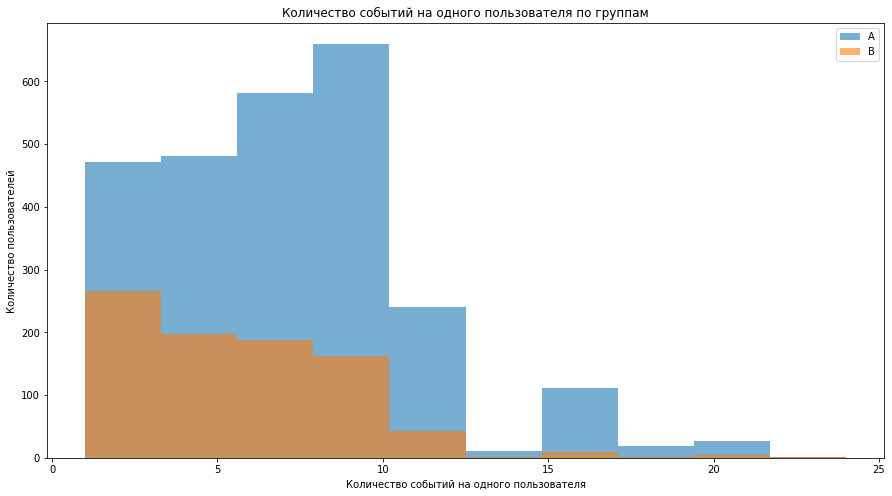

In [25]:
#Посмотрим, как распределено количество событий на пользователя в выборках:
df_a = df.query('group == "A"')
df_b = df.query('group == "B"')



#построим совмещённый график изменений
ax = df_a.groupby(['user_id']).agg({'event_name':'count'}).plot(kind='hist', alpha=0.6)
df_b.groupby(['user_id']).agg({'event_name':'count'}).plot(kind='hist', alpha=0.6, ax=ax)
plt.legend(labels=['A','B'])
plt.title('Количество событий на одного пользователя по группам')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Группа А похоже сильно более активна. Проверим распределение событий по дням

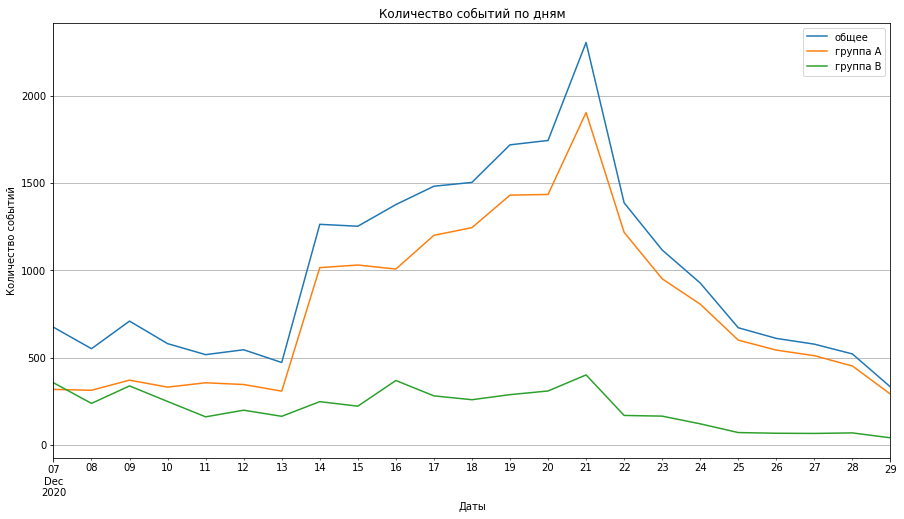

In [26]:

#построим совмещённый график изменений количества событий по дням:
ax = df.groupby(['event_date']).agg({'user_id':'count'}).plot()
df_a.groupby(['event_date']).agg({'user_id':'count'}).plot(ax=ax)
df_b.groupby(['event_date']).agg({'user_id':'count'}).plot(ax=ax)
plt.legend(labels=['общее','группа A','группа B'])
plt.grid()
plt.title('Количество событий по дням')
plt.xlabel('Даты')
plt.ylabel('Количество событий')
plt.show()

Похоже после 21 декабря 2020 в количестве событий идет спад. Возможно это связано с началом 25.12.2020 наркетингового события, которое накладывается на сроки нашего АВ-теста

### Промежуточные выводы

Группа А похоже сильно более активна. Пик событий произошел 21 декабря 2020. Затем в количестве событий идет спад. Возможно это связано с началом 25.12.2020 наркетингового события, которое накладывается на сроки нашего АВ-теста

## Оценка результатов A/B-тестирования

Проверим **статистическую гипотезу №1**  выдвинутую при проведение рассматриваемого нами АВ-теста: 
Группы: А — контрольная, B — новая платёжная воронка;
За 14 дней с момента регистрации пользователи группы В покажут увеличение просмотров карточек товаров (событие product_page) не менее, чем на 10%.


Для проведения гипотезы установим уровень статистической значимости, равный 5% (alpha = 0.05). 

Также, определим гипотезы для проверки.

$H_0$ **Статистически значимых различий** между группами А и В с точки зрения изменения просмотров **нет**.

$H_1$ **Статистически значимые различия** между группами А и В с точки зрения изменения просмотров **есть**.


In [30]:
#проверим первую гипотезу (о product_page)
#установим уровень статистической значимости
alpha = 0.05

# подготовим переменные
successes_1 = df_a.loc[df_a['event_name']=='product_page', 'user_id'].nunique()
successes_2 = df_b.loc[df_b['event_name']=='product_page', 'user_id'].nunique()
trials_1 = groups_cnt.loc[groups_cnt['group'] == 'A', 'user_id'].values[0]
trials_2 = groups_cnt.loc[groups_cnt['group'] == 'B', 'user_id'].values[0]

successes_combined = np.array([successes_1, successes_2])
trials_combined = np.array([trials_1, trials_2])
    
# проведём расчеты
stat, p_val = proportions_ztest(successes_combined, trials_combined, alternative='two-sided')

# выведем результаты
print('p-значение: ',p_val.round(4))
print(f'Доля пользователей, сделавших событие "product_page":')
print(f'Для группы A - {successes_1/trials_1:.2%}')
print(f'Для группы B - {successes_2/trials_2:.2%}')
print(' ')
if p_val < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
print(' ')

p-значение:  0.0
Доля пользователей, сделавших событие "product_page":
Для группы A - 46.37%
Для группы B - 18.15%
 
Отвергаем нулевую гипотезу
 


У нас **есть статистически достоверная разница между группами А и В**. Разница в целевом действии есть, но эти изменения не соответсвуют ожидаемым - контрольная группа демонстрирует заметно лучшие результаты.

Проверим **статистическую гипотезу №2**  выдвинутую при проведение рассматриваемого нами АВ-теста: 
Группы: А — контрольная, B — новая платёжная воронка;
За 14 дней с момента регистрации пользователи группы В покажут увеличение просмотров корзины (событие product_cart), не менее, чем на 10%.


Для проведения гипотезы установим уровень статистической значимости, равный 5% (alpha = 0.05). 

Также, определим гипотезы для проверки.

$H_0$ **Статистически значимых различий** между группами А и В с точки зрения изменения просмотров **нет**.

$H_1$ **Статистически значимые различия** между группами А и В с точки зрения изменения просмотров **есть**.


In [34]:
#проверим вторую гипотезу (о  product_cart)
#установим уровень статистической значимости
alpha = 0.05

# подготовим переменные
successes_1 = df_a.loc[df_a['event_name']=='product_cart', 'user_id'].nunique()
successes_2 = df_b.loc[df_b['event_name']=='product_cart', 'user_id'].nunique()
trials_1 = groups_cnt.loc[groups_cnt['group'] == 'A', 'user_id'].values[0]
trials_2 = groups_cnt.loc[groups_cnt['group'] == 'B', 'user_id'].values[0]

successes_combined = np.array([successes_1, successes_2])
trials_combined = np.array([trials_1, trials_2])
    
# проведём расчеты
stat, p_val = proportions_ztest(successes_combined, trials_combined, alternative='two-sided')

# выведем результаты
print('p-значение: ',p_val.round(4))
print(f'Доля пользователей, сделавших событие "product_cart":')
print(f'Для группы A - {successes_1/trials_1:.2%}')
print(f'Для группы B - {successes_2/trials_2:.2%}')
print(' ')
if p_val < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
print(' ')

p-значение:  0.0
Доля пользователей, сделавших событие "product_cart":
Для группы A - 21.52%
Для группы B - 8.98%
 
Отвергаем нулевую гипотезу
 


У нас **есть статистически достоверная разница между группами А и В**. Разница в целевом действии есть, но эти изменения не соответсвуют ожидаемым - контрольная группа демонстрирует заметно лучшие результаты.

Проверим **статистическую гипотезу №3**  выдвинутую при проведение рассматриваемого нами АВ-теста: 
Группы: А — контрольная, B — новая платёжная воронка;
За 14 дней с момента регистрации пользователи группы В покажут увеличение покупок (событие purchase), не менее, чем на 10%.


Для проведения гипотезы установим уровень статистической значимости, равный 5% (alpha = 0.05). 

Также, определим гипотезы для проверки.

$H_0$ **Статистически значимых различий** между группами А и В с точки зрения изменения количества покупок **нет**.

$H_1$ **Статистически значимые различия** между группами А и В с точки зрения изменения количества покупок  **есть**.

In [29]:
#проверим третью гипотезу (о  purchase)
#установим уровень статистической значимости
alpha = 0.05

# подготовим переменные
successes_1 = df_a.loc[df_a['event_name']=='purchase', 'user_id'].nunique()
successes_2 = df_b.loc[df_b['event_name']=='purchase', 'user_id'].nunique()
trials_1 = groups_cnt.loc[groups_cnt['group'] == 'A', 'user_id'].values[0]
trials_2 = groups_cnt.loc[groups_cnt['group'] == 'B', 'user_id'].values[0]

successes_combined = np.array([successes_1, successes_2])
trials_combined = np.array([trials_1, trials_2])
    
# проведём расчеты
stat, p_val = proportions_ztest(successes_combined, trials_combined, alternative='two-sided')

# выведем результаты
print('p-значение: ',p_val.round(4))
print(f'Доля пользователей, сделавших событие "purchase":')
print(f'Для группы A - {successes_1/trials_1:.2%}')
print(f'Для группы B - {successes_2/trials_2:.2%}')
print(' ')
if p_val < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
print(' ')

p-значение:  0.0
Доля пользователей, сделавших событие "purchase":
Для группы A - 22.92%
Для группы B - 9.16%
 
Отвергаем нулевую гипотезу
 


У нас **есть статистически достоверная разница между группами А и В**. Разница в целевом действии есть, но эти изменения не соответсвуют ожидаемым - контрольная группа демонстрирует заметно лучшие результаты.

### Промежуточные выводы

Во всех трех выдвинутых гипотезах у нас **есть статистически достоверная разница между группами А и В**. Разница в целевом действии есть, но эти изменения не соответсвуют ожидаемым - контрольная группа демонстрирует заметно лучшие результаты.

## Выводы


В процессе получения и предобработки данных мы выяснили, что данные чистые и их хватает для анализа. Дополнительно мы перевели столбцы времени в формат даты. А также переименовали все столбцы с dt в date. Задвоения пользователей у нас в группах нет.

В процессе оценки корректности АВ-теста мы выяснили, что задвоения в нашем тесте у новых пользователей нет. Количество пользователей и процент новых пользователей соответсвует техническому заданию. Но у нас есть 12,3% пользователей АВ-теста, которые одновременно участвовали в другом тесте. Судя по названию, это тест изменений в интерфейсе и он мог в полной мере повлиять на наше тестирование изменений связанных с внедрением улучшенной рекомендательной системы. Наличие такого большого пересечения с АВ-тестом изменений которые могли сильно повлиять на наш тест делает наш АВ-тест некорректным. Распределение пользователей по группам в целом равномерное. Со временем нашего теста совпадает Christmas&New Year Promo который может вносить свои коррективы и делать АВ-тест, что мы рассматриваем некорректно проведенным. По сумме замечаний, **я считаю что проверяемый нами АВ-тест проведен некорректно**.

Исследовательский анализ показал, что руппа А похоже сильно более активна. Пик событий произошел 21 декабря 2020. Затем в количестве событий идет спад. Возможно это связано с началом 25.12.2020 наркетингового события, которое накладывается на сроки нашего АВ-теста.

Анализ результатов теста показал, что во всех трех выдвинутых гипотезах у нас **есть статистически достоверная разница между группами А и В**. Разница в целевом действии есть, но эти изменения не соответсвуют ожидаемым - контрольная группа демонстрирует заметно лучшие результаты.


**Рекомендации**

Оцениваемый АВ-тест оказался крайне неудачен. Я рекомендую использовать данные результаты как образец изменений, негативно воспринятых пользователями и при последующих АВ-тестах учитывать это. 
Также я рекомендую оценить результаты теста interface_eu_test - возможно катастрофическое падение событий к концу рассматриваемого нами АВ-теста это результат наложения на наши изменения изменений в интерфейсе. Возможно пользователи просто не могли выполнить те действия, которые мы от них ждали